# DashToon - Artisitic Style Transfer

This is an implementation of neural style transfer using CNN's by  [Gatys (2015)](https://arxiv.org/abs/1508.06576)

This paper suggests that certain layers of the ConvNet influence the content of the image and the covariance between certain layers (gram matrix) represents the style of the image. Hence by taking an MSE loss for the content and style representation we can do artistic style transfer.

The model architecute is the VGG19 model.

Many implementations of this paper are available online but they seem to support only a single style image and not multiple style images. So I have adapted [this implementation](https://github.com/pamruta/Style-Transfer/) by taking the average of the features of the style layers of the ConvNet as the target

Dependencies:<br>
Pytorch: pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118<br>
PIL: pip install Pillow<br>
Matplotlib: pip install matplotlib

Place the content image(single) in a folder called content_reference and style images in a folder called style_reference

In [1]:
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_folder):
    images = torch.stack([loader(Image.open(image_folder + '/' + image_name)) for image_name in os.listdir(image_folder)])
    return images.to(device, torch.float)


style_img = image_loader("style_reference")
content_img = image_loader("content_reference")

print(style_img.size())
print(content_img.size())

torch.Size([2, 3, 512, 512])
torch.Size([1, 3, 512, 512])


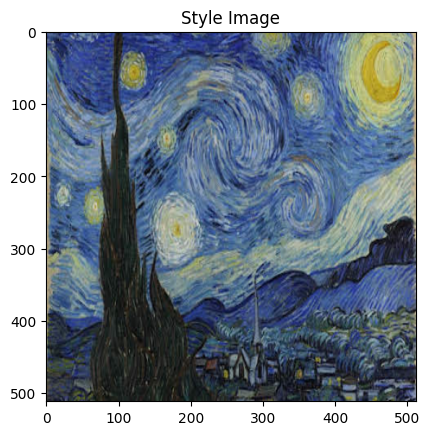

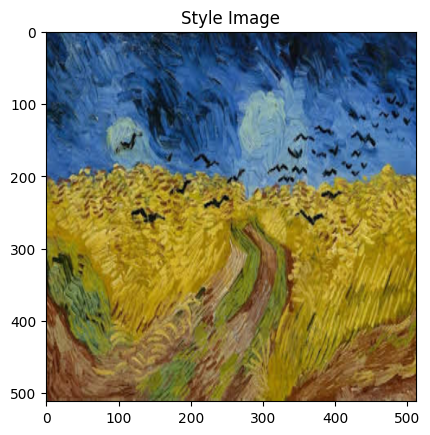

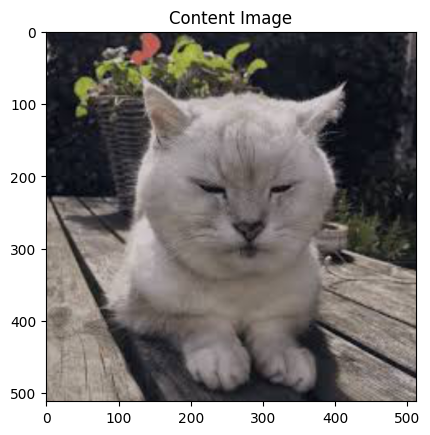

In [4]:
# visualizing the content and style images
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    for img in image:
      img = unloader(img)
      plt.imshow(img)
      if title is not None:
          plt.title(title)
      plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [8]:
# importing vgg-19 pre-trained model
cnn = models.vgg19(weights='DEFAULT').features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\13920/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            #taking average style loss across all images
            target_feature = torch.mean(torch.stack([model(im.unsqueeze(0)).detach() for im in style_img]),0)
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

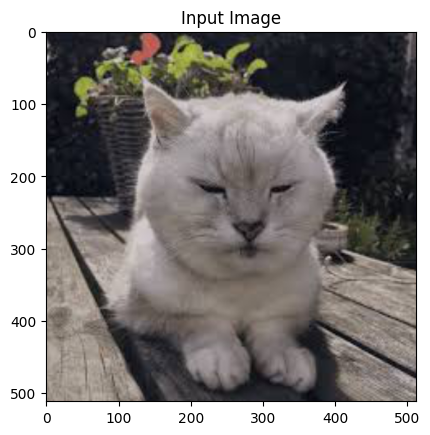

In [12]:
input_img = content_img.clone()
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 177.892792 Content Loss: 9.333082

run [100]:
Style Loss : 102.624527 Content Loss: 9.735174

run [150]:
Style Loss : 77.485588 Content Loss: 10.056186

run [200]:
Style Loss : 69.647423 Content Loss: 10.062410

run [250]:
Style Loss : 66.407463 Content Loss: 10.072736

run [300]:
Style Loss : 64.544319 Content Loss: 10.088891

run [350]:
Style Loss : 63.232567 Content Loss: 10.097832

run [400]:
Style Loss : 62.221596 Content Loss: 10.098253

run [450]:
Style Loss : 61.387314 Content Loss: 10.097114

run [500]:
Style Loss : 60.687523 Content Loss: 10.095123



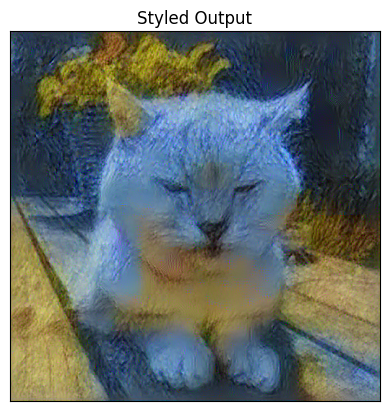

In [15]:
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=500)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()

For the evaluation criteria we can consider the style loss and content loss of the test images to determine the stylistic accuracy and content preservation

## Limitations and Improvements

The model only works for artistic style transfer and not for transfering semantics (for e.g. if we provide anime character as the style and a human face as the content the colour of the anime character is being transferred but semantic aspects like big eyes, hairstyle are not transferred). Similar problems occur when we want to transfer style to certain parts of the content image based on semantics (e.g. border colour, object style, background style). For these more complex style transfer scenarios we might require diffusion model based style transfer based on clip embeddings.